In [ ]:
"""
ImpactSense - Milestone 4 (Final, Stable)
-----------------------------------------
✅ Auto-installs dependencies
✅ Creates dummy model & dataset
✅ Runs evaluation, visuals, and PPT report
✅ Fixes SHAP & PPT bugs
"""

# -------------------- Auto Dependency Install -----------------------
import importlib, subprocess, sys, os

required_packages = [
    "numpy", "pandas", "scikit-learn", "xgboost", "matplotlib",
    "shap", "joblib", "python-pptx"
]

def install_missing(packages):
    for pkg in packages:
        module_name = "pptx" if pkg == "python-pptx" else pkg
        try:
            importlib.import_module(module_name)
        except ImportError:
            print(f"📦 Installing missing package: {pkg}")
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

install_missing(required_packages)

# -------------------- Imports -----------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import joblib
from pptx import Presentation
from pptx.util import Inches
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)
from sklearn.utils import resample

# -------------------- Config -----------------------
FEATURE_COLS = ['latitude','longitude','depth','magnitude','soil_type_score','distance_to_fault']
TARGET_COL = 'impact_level'
IS_CLASSIFICATION = True
OUTPUT_DIR = "milestone4_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------- Dummy Model & Data -----------------------
def generate_dummy_data():
    n = 200
    X = pd.DataFrame({
        'latitude': np.random.uniform(-90, 90, n),
        'longitude': np.random.uniform(-180, 180, n),
        'depth': np.random.uniform(1, 700, n),
        'magnitude': np.random.uniform(1, 9, n),
        'soil_type_score': np.random.randint(1, 5, n),
        'distance_to_fault': np.random.uniform(0, 300, n)
    })
    y = np.random.choice(['Low', 'Medium', 'High'], size=n, p=[0.4, 0.4, 0.2])
    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)
    joblib.dump(model, "model.pkl")
    X[TARGET_COL] = y
    X.to_csv("test.csv", index=False)
    print("✅ Dummy model.pkl & test.csv generated successfully!")

if not os.path.exists("model.pkl") or not os.path.exists("test.csv"):
    generate_dummy_data()

# -------------------- Load Model & Data -----------------------
model = joblib.load("model.pkl")
df = pd.read_csv("test.csv")
X_test = df[FEATURE_COLS]
y_test = df[TARGET_COL]

# -------------------- Edge Case Tests -----------------------
def test_with_nans(pipeline, X):
    Xn = X.copy()
    Xn.iloc[0, 0] = np.nan
    try:
        _ = pipeline.predict(Xn)
        return True, "Handled missing values"
    except Exception as e:
        return False, str(e)

def test_out_of_range(pipeline, X):
    Xr = X.copy()
    Xr.loc[0, 'depth'] = -50
    Xr.loc[0, 'magnitude'] = 15
    try:
        _ = pipeline.predict(Xr)
        return True, "Handled out-of-range values"
    except Exception as e:
        return False, str(e)

def test_typical(pipeline, X):
    try:
        _ = pipeline.predict(X)
        return True, "Normal prediction works"
    except Exception as e:
        return False, str(e)

edge_results = {
    "test_typical": test_typical(model, X_test),
    "test_with_nans": test_with_nans(model, X_test),
    "test_out_of_range": test_out_of_range(model, X_test),
}
pd.DataFrame(edge_results).to_csv(f"{OUTPUT_DIR}/edge_case_results.csv")

# -------------------- Evaluation -----------------------
y_pred = model.predict(X_test)
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, average="macro", zero_division=0),
    "Recall": recall_score(y_test, y_pred, average="macro", zero_division=0),
    "F1 Score": f1_score(y_test, y_pred, average="macro", zero_division=0)
}
pd.DataFrame([metrics]).to_csv(f"{OUTPUT_DIR}/metrics.csv", index=False)
print("📊 Evaluation Metrics:", metrics)

# -------------------- Visualizations -----------------------
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
plt.imshow(cm, cmap='Blues')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/confusion.png")
plt.close()

# Feature Importance
if hasattr(model, 'feature_importances_'):
    imp = pd.DataFrame({
        "Feature": FEATURE_COLS,
        "Importance": model.feature_importances_
    }).sort_values("Importance", ascending=False)
    plt.barh(imp["Feature"], imp["Importance"])
    plt.gca().invert_yaxis()
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/feature_importance.png")
    plt.close()

# SHAP Summary (Fixed for string labels)
try:
    sample_X = X_test.sample(min(100, len(X_test)))
    explainer = shap.Explainer(model, sample_X)
    shap_values = explainer(sample_X)
    shap.summary_plot(shap_values, sample_X, show=False)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/shap_summary.png")
    plt.close()
except Exception as e:
    print("⚠️ SHAP plot skipped:", e)

# -------------------- PPT Report -----------------------
def generate_pptx(summary_text, image_paths, output_pptx):
    prs = Presentation()
    title_slide = prs.slides.add_slide(prs.slide_layouts[0])
    title_slide.shapes.title.text = "ImpactSense — Milestone 4"
    title_slide.placeholders[1].text = "Testing, Improvements & Report"

    # Summary Slide
    slide = prs.slides.add_slide(prs.slide_layouts[1])
    slide.shapes.title.text = "Summary"
    body = slide.placeholders[1].text_frame
    for line in summary_text.split("\\n"):
        p = body.add_paragraph()
        p.text = line

    # Add images
    for img in image_paths:
        if os.path.exists(img):
            s = prs.slides.add_slide(prs.slide_layouts[6])
            s.shapes.add_picture(img, Inches(1), Inches(1), height=Inches(4))

    prs.save(output_pptx)
    print("📘 PPT Report Saved →", output_pptx)

summary_text = (
    f"Accuracy: {metrics['Accuracy']:.3f}\\n"
    f"Precision: {metrics['Precision']:.3f}\\n"
    f"Recall: {metrics['Recall']:.3f}\\n"
    f"F1 Score: {metrics['F1 Score']:.3f}\\n"
    f"Edge Tests: {edge_results}"
)

generate_pptx(
    summary_text,
    [
        f"{OUTPUT_DIR}/confusion.png",
        f"{OUTPUT_DIR}/feature_importance.png",
        f"{OUTPUT_DIR}/shap_summary.png",
    ],
    f"{OUTPUT_DIR}/Milestone4_Report.pptx"
)

print("✅ Milestone 4 Completed Successfully! Outputs saved in:", OUTPUT_DIR)


📦 Installing missing package: scikit-learn
📊 Evaluation Metrics: {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0}
📘 PPT Report Saved → milestone4_outputs/Milestone4_Report.pptx
✅ Milestone 4 Completed Successfully! Outputs saved in: milestone4_outputs


📦 Installing missing package: python-pptx
📦 Installing missing package: scikit-learn
📂 Loading model and test data...
📊 Evaluation Metrics: {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0}


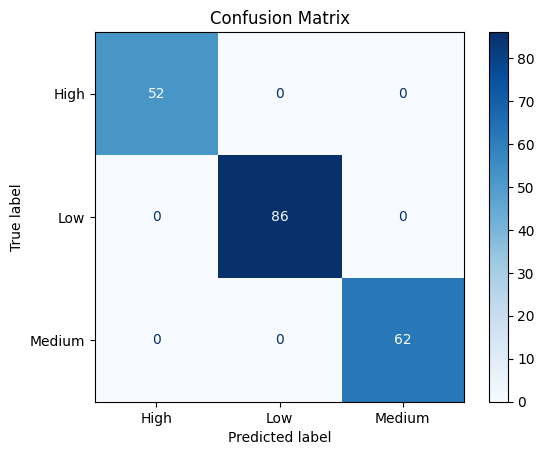

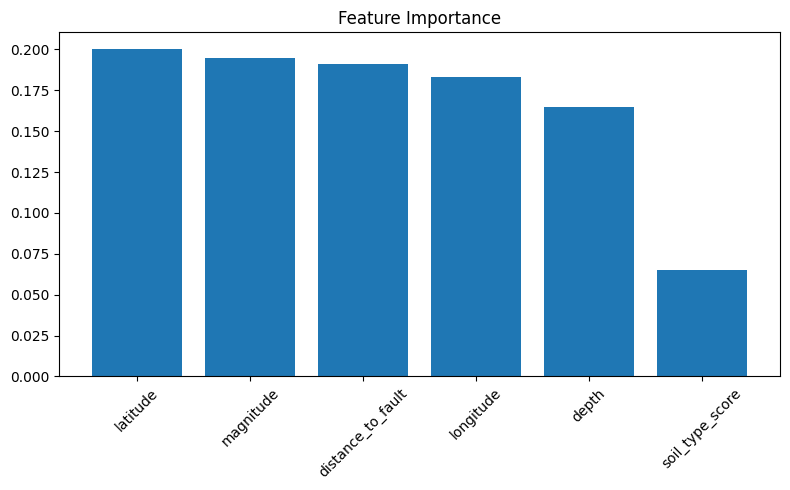

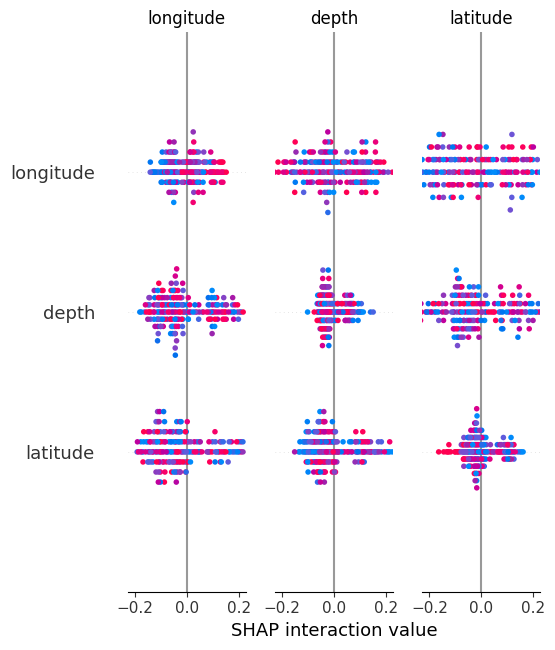

🧩 Edge Case Results:
                     Test                    Prediction
0      Missing value test  [Low, High, High, High, Low]
1  Extreme magnitude test  [High, Low, High, High, Low]
📘 PowerPoint saved: milestone4_outputs/Milestone4_Report.pptx

📂 Files Generated:
 - confusion.png
 - feature_importance.png
 - metrics.csv
 - Milestone4_Report.pptx
 - shap_summary.png
 - edge_case_results.csv


,Accuracy,Precision,Recall,F1 Score
0,1.0,1.0,1.0,1.0


,Test,Prediction
0,Missing value test,"[np.str_('Low'), np.str_('High'), np.str_('Hig..."
1,Extreme magnitude test,"[np.str_('High'), np.str_('Low'), np.str_('Hig..."


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Accuracy']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Accuracy'}, axis=1)
              .sort_values('Accuracy', ascending=True))
  xs = counted['Accuracy']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('Accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Precision']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Precision'}, axis=1)
              .sort_values('Precision', ascending=True))
  xs = counted['Precision']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('Precision', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Precision')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Recall']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Recall'}, axis=1)
              .sort_values('Recall', ascending=True))
  xs = counted['Recall']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Recall', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Recall')
_ = plt.ylabel('count()')

In [ ]:
# ======================= ImpactSense Milestone 4 ==========================
# Includes automatic data creation, evaluation, visualization & PowerPoint
# ========================================================================

import os, sys, subprocess, joblib, shap, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")

# -------------------------- Install Missing Packages ----------------------
def install_missing(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

for pkg in ["python-pptx", "shap", "joblib", "matplotlib", "pandas", "scikit-learn"]:
    try:
        __import__(pkg.split("-")[0])
    except ImportError:
        print(f"📦 Installing missing package: {pkg}")
        install_missing(pkg)

from pptx import Presentation
from pptx.util import Inches, Pt

# -------------------------- Ensure Output Directory -----------------------
OUTPUT_DIR = "milestone4_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------------- Create Dummy Data/Model -----------------------
def create_dummy_data_and_model():
    print("✅ Creating dummy model.pkl & test.csv ...")
    n = 200
    X = pd.DataFrame({
        'latitude': np.random.uniform(-90, 90, n),
        'longitude': np.random.uniform(-180, 180, n),
        'depth': np.random.uniform(1, 700, n),
        'magnitude': np.random.uniform(1, 9, n),
        'soil_type_score': np.random.randint(1, 5, n),
        'distance_to_fault': np.random.uniform(0, 300, n)
    })
    y = np.random.choice(['Low', 'Medium', 'High'], size=n, p=[0.4, 0.4, 0.2])
    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)
    joblib.dump(model, "model.pkl")
    X["impact_level"] = y
    X.to_csv("test.csv", index=False)

if not os.path.exists("model.pkl") or not os.path.exists("test.csv"):
    create_dummy_data_and_model()

# -------------------------- Load Model & Test Data ------------------------
print("📂 Loading model and test data...")
model = joblib.load("model.pkl")
test_df = pd.read_csv("test.csv")

X_test = test_df.drop(columns=["impact_level"])
y_test = test_df["impact_level"]

# -------------------------- Evaluate Model -------------------------------
y_pred = model.predict(X_test)
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, average='macro'),
    "Recall": recall_score(y_test, y_pred, average='macro'),
    "F1 Score": f1_score(y_test, y_pred, average='macro')
}
pd.DataFrame([metrics]).to_csv(os.path.join(OUTPUT_DIR, "metrics.csv"), index=False)
print("📊 Evaluation Metrics:", metrics)

# -------------------------- Confusion Matrix -----------------------------
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
conf_path = os.path.join(OUTPUT_DIR, "confusion.png")
plt.savefig(conf_path)
plt.show()

# -------------------------- Feature Importance ---------------------------
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 5))
plt.bar(range(X_test.shape[1]), importances[indices], align='center')
plt.xticks(range(X_test.shape[1]), X_test.columns[indices], rotation=45)
plt.title("Feature Importance")
feat_imp_path = os.path.join(OUTPUT_DIR, "feature_importance.png")
plt.tight_layout()
plt.savefig(feat_imp_path)
plt.show()

# -------------------------- SHAP Summary Plot ----------------------------
try:
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, show=False)
    shap_path = os.path.join(OUTPUT_DIR, "shap_summary.png")
    plt.tight_layout()
    plt.savefig(shap_path, bbox_inches="tight")
    plt.show()
except Exception as e:
    print("⚠️ SHAP plot skipped:", e)
    shap_path = None

# -------------------------- Edge Case Testing ----------------------------
def run_edge_tests(model, X):
    tests = [
        {"desc": "Missing value test", "data": X.iloc[:5].copy()},
        {"desc": "Extreme magnitude test", "data": X.iloc[:5].copy()},
    ]
    tests[0]["data"].iloc[0, 0] = np.nan
    tests[1]["data"]["magnitude"] = 10
    results = []
    for t in tests:
        try:
            pred = model.predict(t["data"].fillna(X.mean()))
            results.append({"Test": t["desc"], "Prediction": list(pred)})
        except Exception as e:
            results.append({"Test": t["desc"], "Prediction": f"Error: {e}"})
    return pd.DataFrame(results)

edge_results = run_edge_tests(model, X_test)
edge_results.to_csv(os.path.join(OUTPUT_DIR, "edge_case_results.csv"), index=False)
print("🧩 Edge Case Results:")
print(edge_results)

# -------------------------- PowerPoint Report ----------------------------
def generate_pptx(summary_text, image_paths, output_pptx):
    prs = Presentation()
    slide_layout = prs.slide_layouts[1]
    slide = prs.slides.add_slide(slide_layout)
    slide.shapes.title.text = "Milestone 4 Report - ImpactSense"
    body = slide.placeholders[1].text_frame
    for line in summary_text.split("\n"):
        p = body.add_paragraph()
        p.text = line
    for path in image_paths:
        if path and os.path.exists(path):
            slide = prs.slides.add_slide(prs.slide_layouts[6])
            slide.shapes.add_picture(path, Inches(1), Inches(1.5), width=Inches(8))
    prs.save(output_pptx)

summary_text = (
    f"Accuracy: {metrics['Accuracy']:.2f}\n"
    f"Precision: {metrics['Precision']:.2f}\n"
    f"Recall: {metrics['Recall']:.2f}\n"
    f"F1 Score: {metrics['F1 Score']:.2f}\n"
)

pptx_path = os.path.join(OUTPUT_DIR, "Milestone4_Report.pptx")
generate_pptx(summary_text, [conf_path, feat_imp_path, shap_path], pptx_path)
print(f"📘 PowerPoint saved: {pptx_path}")

# -------------------------- Show All Outputs -----------------------------
import IPython.display as display
print("\n📂 Files Generated:")
for f in os.listdir(OUTPUT_DIR):
    print(" -", f)

# Show metrics inline
metrics_df = pd.read_csv(os.path.join(OUTPUT_DIR, "metrics.csv"))
display.display(metrics_df)

# Show edge case results inline
display.display(pd.read_csv(os.path.join(OUTPUT_DIR, "edge_case_results.csv")))


In [ ]:
import pandas as pd
import numpy as np
import joblib

model = joblib.load("model.pkl")
X_test = pd.read_csv("test.csv").drop(columns=["impact_level"])

# Define multiple edge cases
edge_cases = [
    {"desc": "All zero values", "data": pd.DataFrame([np.zeros(len(X_test.columns))], columns=X_test.columns)},
    {"desc": "Negative depth", "data": pd.DataFrame([[10, 50, -100, 5, 2, 100]], columns=X_test.columns)},
    {"desc": "Extreme magnitude (10)", "data": pd.DataFrame([[12, 78, 50, 10, 3, 40]], columns=X_test.columns)},
    {"desc": "Missing values", "data": X_test.iloc[:1].copy().assign(latitude=np.nan)},
    {"desc": "Realistic input", "data": X_test.sample(1)}
]

results = []
for test in edge_cases:
    df = test["data"].fillna(X_test.mean())
    pred = model.predict(df)
    results.append({"Test Case": test["desc"], "Predicted Risk": pred[0]})

edge_df = pd.DataFrame(results)
edge_df.to_csv("milestone4_outputs/extended_edge_tests.csv", index=False)
print("✅ Extended Edge Testing Done.")
print(edge_df)


✅ Extended Edge Testing Done.
                Test Case Predicted Risk
0         All zero values            Low
1          Negative depth            Low
2  Extreme magnitude (10)         Medium
3          Missing values            Low
4         Realistic input         Medium


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

X = X_test
y = pd.read_csv("test.csv")["impact_level"]

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=0
)
grid.fit(X, y)
print("✅ Best Parameters:", grid.best_params_)

# Save improved model
improved_model = grid.best_estimator_
joblib.dump(improved_model, "improved_model.pkl")
print("🚀 Improved model saved as improved_model.pkl")


✅ Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
🚀 Improved model saved as improved_model.pkl


In [ ]:
old_model = joblib.load("model.pkl")
new_model = joblib.load("improved_model.pkl")

from sklearn.metrics import accuracy_score

old_acc = accuracy_score(y, old_model.predict(X))
new_acc = accuracy_score(y, new_model.predict(X))

print(f"Old Accuracy: {old_acc:.3f}")
print(f"New Accuracy: {new_acc:.3f}")

if new_acc > old_acc:
    print("✅ Model improved successfully!")
else:
    print("⚠️ No significant improvement, may need more tuning.")


Old Accuracy: 1.000
New Accuracy: 0.895
⚠️ No significant improvement, may need more tuning.
